# Calculate/convert required variables for daily and hourly TMY

### Variables in output files:

#### Daily:
- Max dry bulb temperature
- Min dry bulb temperature
- Mean dry bulb temperature
- Max dew point temperature
- Min dew point temperature
- Mean dew point temperature
- Max wind speed
- Mean wind speed
- Global solar irradiance
- Direct solar irradiance

#### Hourly:
- Dry bulb temperature
- Wet bulb temperature
- Absolute moisture content
- Atmospheric pressure
- Wind speed
- Wind direction
- Global solar irradiance
- Direct solar irradiance
- Diffuse solar irradiance
- Total cloud cover

Using Rob Warren's atmos package (https://github.com/robwarrenwx/atmos/tree/main) to calculate humidity-based variables (dew point, wet bulb temperature, specific humidity). Ref: Warren, R.A. (2025) A consistent treatment of mixed-phase saturation for atmospheric thermodynamics. Quarterly Journal of the Royal Meteorological Society, 151:e4866. Available from: https://doi.org/10.1002/qj.4866


In [1]:
import xarray as xr
import os
import sys
import glob
import numpy as np
import matplotlib.pyplot as plt
from ephem import Sun, Observer, pi, hours

sys.path.append('/home/565/dh4185/mn51-dh4185/repos_collab/atmos/')
from atmos.thermo import dewpoint_temperature
from atmos.thermo import wet_bulb_temperature


In [12]:
# Functions
#< Keep attributes from input datasets
xr.set_options(keep_attrs = True)

def convert_temp_unit(da):
    if da.attrs['units'] not in ('degC', 'K'):
        raise ValueError("The 'unit' argument for tasmax and tasmin is neither 'C' (Celsius) or 'K' (Kelvin).")
    if da.attrs['units'] == 'K':
        da = da - 273.16
        da.attrs['units'] = 'degC'
    return da

def meanVar(varmax,varmin):        
    return (varmax + varmin) / 2.

def solar_time(dt, lat, lon):
    """
    Calculate local solar time (e.g., 12 is local noon)
    """
    sun = Sun()
    sun.compute(dt)
 
    loc = Observer()
    loc.lat = str(lat)
    loc.lon = str(lon)
    loc.date = dt
    ra, dec = loc.radec_of('0', '-90')
 
    return (ra - sun.ra) % (2 * pi) * 12 / np.pi

def dewpoint_temp_minmeanmax(da_psl, da_tas, da_huss):
    dew_1hr = dewpoint_temperature(da_psl, da_tas, da_huss)
    dew_day_max = dew_1hr.resample(time='1D').max()
    dew_day_min = dew_1hr.resample(time='1D').min()
    dew_day_max.attrs['units'] = 'K'
    dew_day_min.attrs['units'] = 'K'
    dew_day_max_fin = convert_temp_unit(dew_day_max).rename('Max_dewpoint_temperature')
    dew_day_min_fin = convert_temp_unit(dew_day_min).rename('Min_dewpoint_temperature')
    dew_day_mean_fin = meanVar(dew_day_max_fin,dew_day_min_fin).rename('Mean_dewpoint_temperature')
    
    return dew_day_max_fin, dew_day_mean_fin, dew_day_min_fin

def wind_dir_index(uas,vas,wind_speed):
    wind_dir_degrees = np.degrees(np.arctan2(uas,vas)) % 360
    
    compass_points = ["NNE", "NE", "ENE", "E", "ESE", "SE", "SSE",
                      "S", "SSW", "SW", "WSW", "W", "WNW", "NW", "NNW","N"]
    compass_index = list(range(1, 17))
    
    # Shift by -11.25° to make N fall into index 15 (i.e. value 16)
    index = ((wind_dir_degrees - 11.25) % 360) / 22.5
    bin_index = index.astype(int)
    wind_dir_index = bin_index.where(bin_index.notnull(), other=np.nan) # Handle NaNs if present
    
    # Map the compass index against wind direction 
    wind_dir_index_mapped = xr.apply_ufunc(
        lambda x: np.array(compass_index)[x],
        bin_index,
        vectorize=True,
        # dask="parallelized", # Use if working with dask-backed xarray objects
        output_dtypes=[int]
    )
    # Mask with 0 where wind speed is <1km/h (1000/3600 m/s).
    wind_dir_index_masked = wind_dir_index_mapped.where(wind_speed>=(1000/3600),wind_dir_index_mapped,0)
    wind_dir_index_masked.attrs['units'] = "index"
    wind_dir_index_masked.attrs['description'] = "0-16, 0=calm, 1=NNE, 16=N"
    return wind_dir_index_masked.rename('Wind_direction')

def cloud_frac_to_oktas(clt_frac):
    bins = [-0.1,1,12.5,25,37.5,50,52.5,75,87.5,100.1]
    # oktas = np.arange(0,9) # 0 to 8

    return xr.apply_ufunc(
        lambda x: np.digitize(x, bins) -1,
        clt_frac,
        input_core_dims=[[]],
        output_core_dims=[[]],
        vectorize=True,
        output_dtypes=[int]
    ).rename('Total_cloud_cover')

In [29]:
input_dir = "/g/data/eg3/nesp_bff/step2_qdc_scaling/BARPA-R/"
output_dir = "/g/data/eg3/nesp_bff/step3_calc_missing_vars/"

In [32]:
files_1hr = sorted(glob.glob(f"{input_dir}*1hr*"))
files_day = sorted(glob.glob(f"{input_dir}*day*"))

for file_day in files_day:
    file_1hr = file_day.replace("day","1hr")
    if file_1hr in files_1hr:
        print("Both files exist. Proceeding...")

        # Open files
        ds_1hr = xr.open_dataset(file_1hr)
        ds_day = xr.open_dataset(file_day)

        ##################################################################
        # WOULD NEED TO ADD STEP HERE TO CONVERT UTC TIME TO LOCAL TIME! #
        ##################################################################

        ####################################### DAILY #######################################
        # Output file name
        filename_day = f"{output_dir}{file_day.split('/')[-1].replace('.nc','_NatHERSvars.nc')}"

        if not os.path.exists(filename_day):
            
            #### Dry bulb temperature (max/min/mean)
            tasmax = convert_temp_unit(ds_day['tasmax']).rename('Max_dry_bulb_temperature')
            # tasmax = convert_temp_unit(ds_1hr['tas']).resample(time='1D').max().rename('Max_dry_bulb_temperature') # use hourly data to derive daily max
            tasmin = convert_temp_unit(ds_day['tasmin']).rename('Min_dry_bulb_temperature')
            # tasmin = convert_temp_unit(ds_1hr['tas']).resample(time='1D').min().rename('Min_dry_bulb_temperature') # use hourly data to derive daily min
            tasmean = meanVar(tasmax,tasmin).rename('Mean_dry_bulb_temperature')
            
            #### Dew point temperature (max/min/mean)
            dewmax, dewmean, dewmin = dewpoint_temp_minmeanmax(ds_1hr['psl'], ds_1hr['tas'], ds_1hr['huss'])
            
            #### Wind speed
            sfcWind = ds_1hr['sfcWind'].resample(time='1D').mean().rename('Mean_wind_speed')
            sfcWindmax = ds_day['sfcWindmax'].rename('Max_wind_speed')
            # sfcWindmax = ds_1hr['sfcWind'].resample(time='1D').max().rename('Max_wind_speed') # use hourly data to derive daily max
            
            #### Radiation
            rsds = ds_day['rsds'].rename('Global_solar_irradiance')
            rsdsdir = ds_day['rsdsdir'].rename('Direct_solar_irradiance')
            
            #### Merge all to one dataset
            ds_day_fin = xr.merge([tasmax, tasmin, tasmean,  # temperature components
                              dewmax, dewmin, dewmean,       # moisture components
                              sfcWind, sfcWindmax,           # wind components
                              rsds, rsdsdir])                # radiation components
            # Write to netcdf
            ds_day_fin.to_netcdf(filename_day)
        else:
            print(f"File {filename_day.split('/')[-1]} exists in {output_dir}")

        
        ####################################### Hourly #######################################
        # Output file name
        filename_1hr = f"{output_dir}{file_1hr.split('/')[-1].replace('.nc','_NatHERSvars.nc')}"

        if not os.path.exists(filename_1hr):
    
            #### Temperature
            tas = convert_temp_unit(ds_1hr['tas']).rename('Dry_bulb_temperature')
            
            #### Moisture
            # Wet bulb temoerature using isobaric method which is similar but not identical to temperature read from a wet bulb thermometer.
            # See: https://github.com/robwarrenwx/atmos/blob/main/README.md 
            twbt = wet_bulb_temperature(ds_1hr['psl'],
                                           ds_1hr['tas'],
                                           ds_1hr['huss'],
                                           saturation='isobaric', phase='liquid', polynomial=True)
            twbt = convert_temp_unit(twbt).rename('Wet_bulb_temperature')
            
            huss = (ds_1hr['huss']*1000).rename('Absolute_moisture_content')
            huss.attrs['units'] = 'g/kg'
            
            #### Atmospheric pressure
            psl = (ds_1hr['psl']/1000).rename('Atmospheric_pressure')
            psl.attrs['units'] = 'kPa'
            
            #### Wind Speed
            # Wind direction split into 16th. 0-16, 0=calm, 1=NNE, 16=N 
            sfcWind = ds_1hr['sfcWind'].rename('Wind_speed')
            wind_direction = wind_dir_index(ds_1hr['uas'], ds_1hr['vas'], sfcWind)
            
            ### Radiation
            rsds = ds_1hr['rsds'].rename('Global_soalr_irradiance')
            rsdsdir = ds_1hr['rsdsdir'].rename('Direct_soalr_irradiance')
            rsdsdif = (rsds-rsdsdir).rename('Diffuse_soalr_irradiance')
            
            ### Cloud cover
            # in oktas (0-8)
            clt_okta = cloud_frac_to_oktas(ds_1hr['clt'])
            
            
            #### Merge all to one dataset
            ds_1hr_fin = xr.merge([tas,                 # temperature components
                              twbt, huss,               # moisture components
                              psl,                      # atmospheric pressure
                              sfcWind, wind_direction,  # wind components
                              rsds, rsdsdir,rsdsdif,    # radiation components
                              clt_okta])                # Cloud cover
            # Write to netcdf
            ds_1hr_fin.to_netcdf()
        else:
            print(f"File {filename_day.split('/')[-1]} exists in {output_dir}")

    else:
        print(f"MISSING FILE {file_1hr}!")

Both files exist. Proceeding...
Both files exist. Proceeding...
Both files exist. Proceeding...
Both files exist. Proceeding...
Both files exist. Proceeding...
Both files exist. Proceeding...
Both files exist. Proceeding...
Both files exist. Proceeding...
Both files exist. Proceeding...
Both files exist. Proceeding...
Both files exist. Proceeding...
Both files exist. Proceeding...
Both files exist. Proceeding...
Both files exist. Proceeding...
Both files exist. Proceeding...
Both files exist. Proceeding...
Both files exist. Proceeding...
Both files exist. Proceeding...
Both files exist. Proceeding...
Both files exist. Proceeding...
Both files exist. Proceeding...
Both files exist. Proceeding...
Both files exist. Proceeding...
Both files exist. Proceeding...
Both files exist. Proceeding...
Both files exist. Proceeding...
Both files exist. Proceeding...
Both files exist. Proceeding...
Both files exist. Proceeding...
Both files exist. Proceeding...
Both files exist. Proceeding...
Both fil

/home/565/dh4185/mn51-dh4185/repos_collab/atmos/atmos/thermo.py:1406: RuntimeWarning: All-NaN axis encountered
  if np.nanmax(np.abs(Tw - Tw_prev)) < precision:
/home/565/dh4185/mn51-dh4185/repos_collab/atmos/atmos/thermo.py:1406: RuntimeWarning: All-NaN axis encountered
  if np.nanmax(np.abs(Tw - Tw_prev)) < precision:
/home/565/dh4185/mn51-dh4185/repos_collab/atmos/atmos/thermo.py:1406: RuntimeWarning: All-NaN axis encountered
  if np.nanmax(np.abs(Tw - Tw_prev)) < precision:
/home/565/dh4185/mn51-dh4185/repos_collab/atmos/atmos/thermo.py:1406: RuntimeWarning: All-NaN axis encountered
  if np.nanmax(np.abs(Tw - Tw_prev)) < precision:
/home/565/dh4185/mn51-dh4185/repos_collab/atmos/atmos/thermo.py:1406: RuntimeWarning: All-NaN axis encountered
  if np.nanmax(np.abs(Tw - Tw_prev)) < precision:
/home/565/dh4185/mn51-dh4185/repos_collab/atmos/atmos/thermo.py:1406: RuntimeWarning: All-NaN axis encountered
  if np.nanmax(np.abs(Tw - Tw_prev)) < precision:
/home/565/dh4185/mn51-dh4185/repos

Tw not converged after 20 iterations


IndexError: index -9223372036854775808 is out of bounds for axis 0 with size 16

In [5]:
### This is a function from Christian Stassen to convert to solar time. Not sure what the value is it gives and it only works
# for one time step at a time. Not implemented in the below the values are based on UTC time and day.
solar_time(ds_1hr.isel(time=0).time, ds_1hr.lat.values, ds_1hr.lon.values)

6.627942336752811

## Plot checks

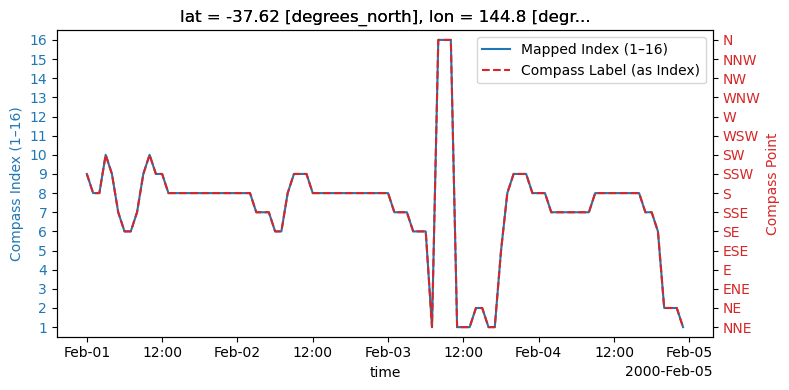

In [45]:
# Plot to check wind direction and compass index output
import matplotlib.pyplot as plt
import xarray as xr

# Create compass points array for validation
wind_dir_compass_mapped = xr.apply_ufunc(
    lambda x: np.array(compass_points)[x],
    bin_index,
    vectorize=True,
    # dask="parallelized", # Use if working with dask-backed xarray objects
    output_dtypes=[str]
)

# Select time slice
t = slice("2000-02-01","2000-02-04")
data_numeric = wind_dir_index_masked.sel(time=t)
data_labels = wind_dir_compass_mapped.sel(time=t)

# Convert compass labels to numeric indices
label_numeric = xr.apply_ufunc(
    lambda x: compass_points.index(x),
    data_labels,
    vectorize=True,
    dask="parallelized",
    output_dtypes=[int]
) + 1

# Create plot
fig, ax1 = plt.subplots(figsize=(8, 4))

# Plot numeric values
data_numeric.plot(ax=ax1, color='tab:blue', label='Mapped Index (1–16)')
ax1.set_ylabel("Compass Index (1–16)", color='tab:blue')
ax1.set_yticks(compass_index)
ax1.set_ylim(0.5, 16.5)
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Twin axis for compass labels
ax2 = ax1.twinx()
label_numeric.plot(ax=ax2, color='tab:red', linestyle='--', label='Compass Label (as Index)')
ax2.set_ylabel("Compass Point", color='tab:red')
ax2.set_yticks(compass_index)
ax2.set_yticklabels(compass_points)
ax2.set_ylim(0.5, 16.5)
ax2.tick_params(axis='y', labelcolor='tab:red')

# Add legend
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')

# Title and layout
# ax1.set_title(f"Comparison of Mapped Wind Direction vs. Compass Labels on {t}")
fig.tight_layout()
plt.show()


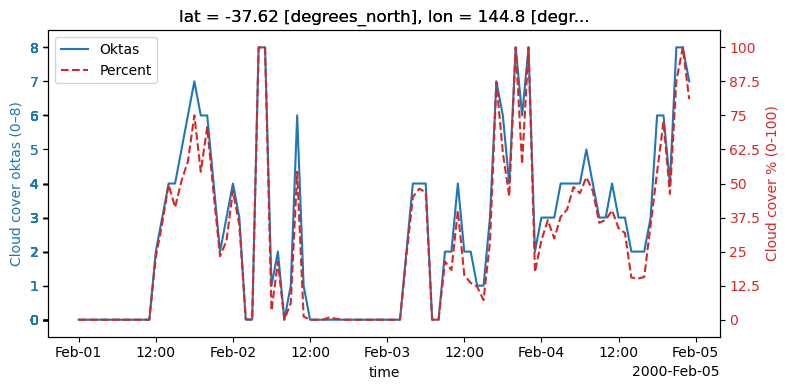

In [18]:
# Plot to check wind direction and compass index output
import matplotlib.pyplot as plt

# Select time slice
t = slice("2000-02-01","2000-02-04")
okta = clt_okta.sel(time=t)
prct = ds_1hr['clt'].sel(time=t)

# Create plot
fig, ax1 = plt.subplots(figsize=(8, 4))

# Plot numeric values
okta.plot(ax=ax1, color='tab:blue', label='Oktas')
ax1.set_ylabel("Cloud cover oktas (0–8)", color='tab:blue')
ax1.set_yticks(okta)
ax1.set_ylim(-0.5, 8.5)
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Twin axis for compass labels
ax2 = ax1.twinx()
prct.plot(ax=ax2, color='tab:red', linestyle='--', label='Percent')
ax2.set_ylabel("Cloud cover % (0-100)", color='tab:red')
ax2.set_yticks([0,12.5,25,37.5,50,62.5,75,87.5,100])
ax2.set_yticklabels([0,12.5,25,37.5,50,62.5,75,87.5,100])
ax2.set_ylim(-6.25, 106.25)
ax2.tick_params(axis='y', labelcolor='tab:red')

# Add legend
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

# Title and layout
# ax1.set_title(f"Comparison of Mapped Wind Direction vs. Compass Labels on {t}")
fig.tight_layout()
plt.show()
